In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
import json
import numpy as np
import pandas as pd
import re
import string
import multiprocessing
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
import joblib
from joblib import Parallel, delayed
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [13]:
save_json_file_path = '/Users/cpan/OneDrive - Guardant Health/clean_test_results/labeled_test_results.json'

In [34]:
def preprocess_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove dates
    text = re.sub(r'\d{1,2}\/\d{1,2}\/\d{4}', '', text)

    # Remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

def custom_tokenizer(text):
    tokens = text.split()  # Split text into tokens
    filtered_tokens = [token for token in tokens if len(token) > 2]  # Exclude tokens with one element
    return filtered_tokens

In [35]:
# preprocess_text = joblib.load('preprocess_text_kmeans.pkl')
vectorizer_kmeans = joblib.load('vectorizer_kmeans.pkl')

In [4]:
data_vectorized_kmeans = joblib.load('data_vectorized_kmeans.pkl')

In [14]:
with open(save_json_file_path, "r") as f:
    data = json.load(f)

In [17]:
# load page content with file names 
all_pages_with_filenames = joblib.load('all_pages_with_filenames.pkl')
all_page_content = joblib.load("all_page_content.pkl")

In [19]:
# all_pages_with_filenames[:2]

In [21]:
# all_page_content[0]

hyperparameters to tune: 
- min_clusters, max_clusters
- n_init: (control number of initializations)
    - default: 10
    - number of times the KMeans algorithm will be run with different initial centroid seeds
    - running the algorithm multiple times with different initializations helps to avoid getting stuck in local minima
    - higher n_init, higher chances of better clustering solution, but more computation time 
- tol: (control the precision of convergence)
    - a stopping criterion for the KMeans algorithm. The algorithm stops iterating when the change in the within-cluster sum of squares from one iteration to the next is less than tol
    - if the centroids have moved very little between iterations, the algorithm considers the solution to have converged. 
    - smaller tol, more iterations 
    - default tol: 1e-4

In [11]:
# hyperparameter tuning with parallel processing 
def kmeans_hyperparameter_tuning(min_clusters, max_clusters):
    data_vectorized_kmeans = joblib.load('data_vectorized_kmeans.pkl')  # Load your data

    best_silhouette_score = -1
    best_kmeans_model = None

    def evaluate_kmeans(num_clusters, n_init, tol):
        kmeans = KMeans(n_clusters=num_clusters, n_init=n_init, tol=tol, random_state=42)
        kmeans.fit(data_vectorized_kmeans)
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(data_vectorized_kmeans, cluster_labels)
        return num_clusters, n_init, tol, silhouette_avg
    results = Parallel(n_jobs=-1)(
    delayed(evaluate_kmeans)(num_clusters, n_init, tol)
    for num_clusters in range(min_clusters, max_clusters + 1)
    for n_init in [5, 10, 20]
    for tol in [1e-4, 1e-3, 1e-2]
)

    for num_clusters, n_init, tol, silhouette_avg in results:
        print(f"For {num_clusters} clusters, n_init={n_init}, tol={tol:.4f}, silhouette score: {silhouette_avg:.4f}")

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_kmeans_model = KMeans(n_clusters=num_clusters, n_init=n_init, tol=tol, random_state=42)
            best_num_clusters = num_clusters

    print(f"Best silhouette score: {best_silhouette_score:.4f}")
    print(f"Optimized number of clusters: {best_num_clusters}") 
    print(f"Best n_init: {best_kmeans_model.n_init}")
    print(f"Best tol: {best_kmeans_model.tol}")
    return best_kmeans_model

In [12]:
# Save the best KMeans model
best_kmeans_model = kmeans_hyperparameter_tuning(2, 16)
joblib.dump(best_kmeans_model, 'best_kmeans_model.pkl')

For 2 clusters, n_init=5, tol=0.0001, silhouette score: 0.0245
For 2 clusters, n_init=5, tol=0.0010, silhouette score: 0.0245
For 2 clusters, n_init=5, tol=0.0100, silhouette score: 0.0245
For 2 clusters, n_init=10, tol=0.0001, silhouette score: 0.0245
For 2 clusters, n_init=10, tol=0.0010, silhouette score: 0.0245
For 2 clusters, n_init=10, tol=0.0100, silhouette score: 0.0245
For 2 clusters, n_init=20, tol=0.0001, silhouette score: 0.0245
For 2 clusters, n_init=20, tol=0.0010, silhouette score: 0.0245
For 2 clusters, n_init=20, tol=0.0100, silhouette score: 0.0245
For 3 clusters, n_init=5, tol=0.0001, silhouette score: 0.0260
For 3 clusters, n_init=5, tol=0.0010, silhouette score: 0.0260
For 3 clusters, n_init=5, tol=0.0100, silhouette score: 0.0260
For 3 clusters, n_init=10, tol=0.0001, silhouette score: 0.0294
For 3 clusters, n_init=10, tol=0.0010, silhouette score: 0.0294
For 3 clusters, n_init=10, tol=0.0100, silhouette score: 0.0294
For 3 clusters, n_init=20, tol=0.0001, silhoue

['best_kmeans_model.pkl']

In [37]:
def fit_kmeans_and_get_top_keywords(data, data_vectorized, vectorizer, num_clusters, num_top_keywords=10, best_kmeans_model=None):
    if best_kmeans_model is None:
        best_kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
        clusters = best_kmeans_model.fit_predict(data_vectorized)
    else:
        clusters = best_kmeans_model.predict(data_vectorized)

    order_centroids = best_kmeans_model.cluster_centers_.argsort()[:, ::-1]
    terms = np.array(vectorizer.get_feature_names_out())

    cluster_keywords = {}
    cluster_file_names = {i: [] for i in range(num_clusters)}

    for cluster_idx in range(num_clusters):
        top_keyword_indices = order_centroids[cluster_idx, :num_top_keywords]
        top_keywords = [terms[idx] for idx in top_keyword_indices]
        cluster_keywords[cluster_idx] = top_keywords

    for idx, (file_name, _) in enumerate(data):
        cluster_file_names[clusters[idx]].append(file_name)

    return best_kmeans_model, clusters, cluster_keywords, cluster_file_names

In [38]:
optimal_clusters = 16 

In [39]:
kmeans, clusters, cluster_keywords, cluster_file_names = fit_kmeans_and_get_top_keywords(all_pages_with_filenames, data_vectorized_kmeans, vectorizer_kmeans, optimal_clusters)

In [40]:
# Save KMeans model, clusters, cluster_keywords, and cluster_file_names
joblib.dump(kmeans, 'best_fitted_kmeans_model.pkl')
joblib.dump(clusters, 'best_kmeans_clusters.pkl')
joblib.dump(cluster_keywords, 'best_kmeans_cluster_keywords.pkl')
joblib.dump(cluster_file_names, 'best_kmeans_cluster_file_names.pkl')

['best_kmeans_cluster_file_names.pkl']

#### KMeans Clustering Visualization

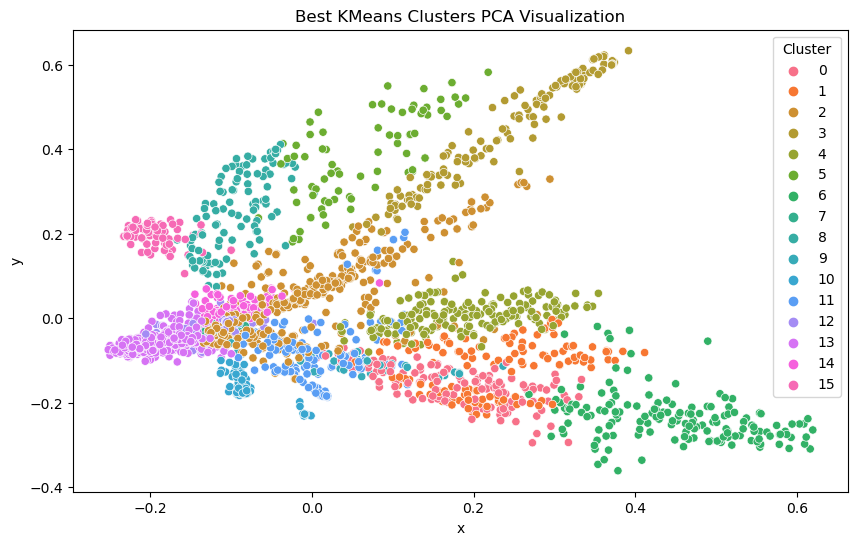

In [42]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vectorized_kmeans.toarray())

# Create a DataFrame with reduced data and cluster labels
cluster_df = pd.DataFrame({'x': reduced_data[:, 0], 'y': reduced_data[:, 1], 'cluster': clusters})

# Set up a colormap
cmap = sns.color_palette("husl", n_colors=optimal_clusters)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df, palette=cmap)
plt.title("Best KMeans Clusters PCA Visualization")
plt.legend(title="Cluster")
plt.show()

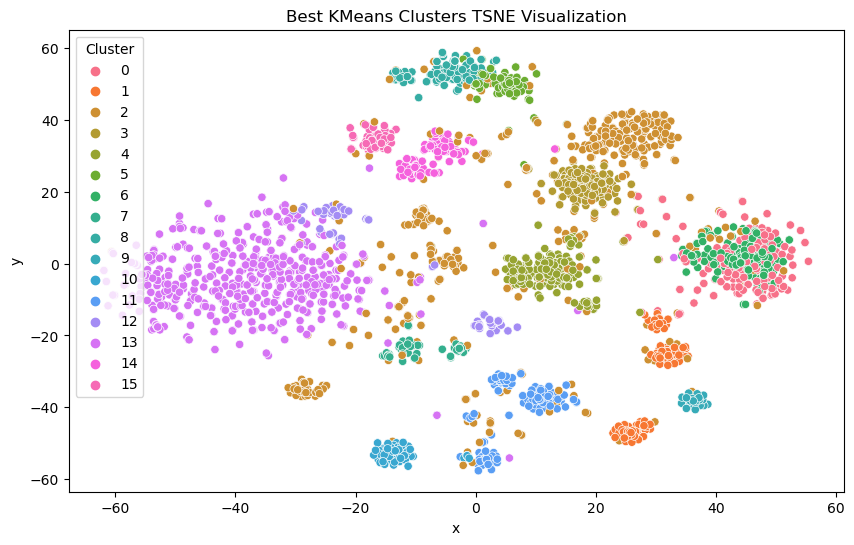

In [44]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(data_vectorized_kmeans.toarray())

# Create a DataFrame with reduced data and cluster labels
cluster_df2 = pd.DataFrame({'x': reduced_data[:, 0], 'y': reduced_data[:, 1], 'cluster': clusters})

# Set up a colormap
cmap = sns.color_palette("husl", n_colors=optimal_clusters)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df2, palette=cmap)
plt.title("Best KMeans Clusters TSNE Visualization")
plt.legend(title="Cluster")
plt.show()

In [61]:
def create_keyword_dataframe(cluster_keywords, num_top_keywords=10):
    data = []
    for cluster_id, keywords in cluster_keywords.items():
        keywords_list = keywords[:num_top_keywords] + ['N/A'] * (num_top_keywords - len(keywords))
        data.append([cluster_id ] + keywords_list)

    columns = ["Cluster"] + [f"Top Keyword {i}" for i in range(num_top_keywords)]
    df = pd.DataFrame(data, columns=columns)
    return df

In [62]:
keywords_df = create_keyword_dataframe(cluster_keywords)

In [63]:
keywords_df

,Cluster,Top Keyword 0,Top Keyword 1,Top Keyword 2,Top Keyword 3,Top Keyword 4,Top Keyword 5,Top Keyword 6,Top Keyword 7,Top Keyword 8,Top Keyword 9
0,0,map,variant,tumor,response,plot,test,date,fraction,portal,guardant
1,1,alteration,detect,amplification,somatic,circulate,cellfree,dna,gene,blood,magnitude
2,2,guardant,portal,service,account,contact,set,detailed,available,client,online
3,3,additional,relevance,email,detailed,available,detect,therapy,result,publicly,annotation
4,4,biomarker,alteration,detect,yes,approve,date,summary,indication,additional,associate
5,5,trial,state,portalguardanthealthcom,phase,available,visit,email,office,title,site
6,6,variant,map,fraction,response,allele,tumor,plot,cfdna,guardant,test
7,7,record,authorization,health,release,disclosure,phone,intend,confidential,transmission,medical
8,8,phase,nct,trial,study,solid,advanced,state,combination,redact,site
9,9,mutmb,tmb,score,alteration,tissue,percentile,somatic,blood,circulate,cellfree


potential clusters with test results keywords:
- cluster 4: biomarker, summary, indication
- cluster 5: variant, tumor
- cluster 8: trial, study
- cluster 10: performance, evidence, biomarker
- cluster 12: result, date
- cluster 13: history, disease, note, lung, negative

### Find Closest Clusters

In [64]:
# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate pairwise distances between cluster centers
distances = cdist(cluster_centers, cluster_centers, metric='euclidean')

# Set diagonal elements (distance to itself) to a large value
np.fill_diagonal(distances, np.inf)

# Find indices of the closest cluster pair
row_idx, col_idx = np.unravel_index(np.argmin(distances), distances.shape)

# Get the actual distance
min_distance = distances[row_idx, col_idx]

# Get the cluster indices
closest_cluster_1 = row_idx
closest_cluster_2 = col_idx

print(f"Clusters {closest_cluster_1} and {closest_cluster_2} are closest with a distance of {min_distance:.4f}")


Clusters 2 and 13 are closest with a distance of 0.2852


In [65]:
# show pairwise distance between cluster centers 

# Calculate pairwise distances between cluster centers
pairwise_distances = cdist(cluster_centers, cluster_centers, metric='euclidean')

# Create a DataFrame to store pairwise distances
pairwise_distances_df = pd.DataFrame(pairwise_distances, index=range(cluster_centers.shape[0]), columns=range(cluster_centers.shape[0]))


In [66]:
pairwise_distances_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.634457,0.381951,0.744845,0.552658,0.714575,0.378044,0.577802,0.651494,0.828993,0.885688,0.534621,0.486857,0.464772,0.531952,0.857311
1,0.634457,0.000000,0.594781,0.815046,0.632341,0.846120,0.741186,0.756470,0.802031,0.740579,0.994520,0.634017,0.685118,0.653514,0.673251,0.979655
2,0.381951,0.594781,0.000000,0.615322,0.489433,0.605290,0.647709,0.445798,0.541348,0.775284,0.817954,0.429881,0.327978,0.285159,0.393455,0.777836
3,0.744845,0.815046,0.615322,0.000000,0.714844,0.713107,0.868749,0.791730,0.794918,0.995320,1.052034,0.757004,0.736711,0.724728,0.743547,1.021243
4,0.552658,0.632341,0.489433,0.714844,0.000000,0.739196,0.698949,0.666321,0.719131,0.849902,0.892642,0.600624,0.594819,0.568369,0.603994,0.906593
5,0.714575,0.846120,0.605290,0.713107,0.739196,0.000000,0.860572,0.757867,0.518946,0.990800,1.036125,0.746554,0.702682,0.681848,0.706689,0.915196
6,0.378044,0.741186,0.647709,0.868749,0.698949,0.860572,0.000000,0.802335,0.839846,0.963835,1.026979,0.727138,0.741293,0.727323,0.753905,1.013565
7,0.577802,0.756470,0.445798,0.791730,0.666321,0.757867,0.802335,0.000000,0.693449,0.894236,0.912402,0.582050,0.500023,0.485105,0.589708,0.900967
8,0.651494,0.802031,0.541348,0.794918,0.719131,0.518946,0.839846,0.693449,0.000000,0.931660,0.980599,0.674613,0.612948,0.584714,0.592040,0.693454
9,0.828993,0.740579,0.775284,0.995320,0.849902,0.990800,0.963835,0.894236,0.931660,0.000000,1.106768,0.836208,0.832402,0.799632,0.820218,1.071885


we need to check the pairwise distances between cluster 4, 5, 8, 10, 12, 13

In [69]:
cluster_indices_of_interest = [2, 4, 5, 8, 10, 12, 13]

# Create a new DataFrame for the selected clusters' pairwise distances
selected_distances_df = pairwise_distances_df.loc[cluster_indices_of_interest, cluster_indices_of_interest]

# Display the new DataFrame
selected_distances_df

,2,4,5,8,10,12,13
2,0.000000,0.489433,0.605290,0.541348,0.817954,0.327978,0.285159
4,0.489433,0.000000,0.739196,0.719131,0.892642,0.594819,0.568369
5,0.605290,0.739196,0.000000,0.518946,1.036125,0.702682,0.681848
8,0.541348,0.719131,0.518946,0.000000,0.980599,0.612948,0.584714
10,0.817954,0.892642,1.036125,0.980599,0.000000,0.862468,0.840622
12,0.327978,0.594819,0.702682,0.612948,0.862468,0.000000,0.335814
13,0.285159,0.568369,0.681848,0.584714,0.840622,0.335814,0.000000


Based on pairwise distance between clusters, and the main keywords from each clusters as following: 
potential clusters with test results keywords:
- cluster 2: gurdant, client, service 
- cluster 4: biomarker, summary, indication
- cluster 5: variant, tumor
- cluster 8: trial, study
- cluster 10: performance, evidence, biomarker
- cluster 12: result, date
- cluster 13: history, disease, note, lung, negative

Analysis: 
- closest clusters based on shortest pairwise distance with a threshold of 0.5 (<=0.5 consider the shorter distances) 
    - cluseter 2, 12, 13
- potential clusters based on top keywords analysis: 
    - cluster 4, 5, 8, 10

In [70]:
closest_key_file_names = cluster_file_names[2]+  cluster_file_names[4]+\
cluster_file_names[5] + cluster_file_names[8] + cluster_file_names[10] + cluster_file_names[12] + cluster_file_names[13]
print(len(closest_key_file_names))

1749


In [71]:
path_txt =  '/Users/cpan/OneDrive - Guardant Health/page_classification_data/'
output_file_path = 'best_kmeans_closest_key_file_names.txt'

# Write the file names to the output text file
with open(path_txt + output_file_path, 'w') as file:
    for file_name in closest_key_file_names:
        file.write(f"{file_name}\n")

print("File names exported to:", output_file_path)

File names exported to: best_kmeans_closest_key_file_names.txt
